Đã lưu kết quả: result_1.jpg


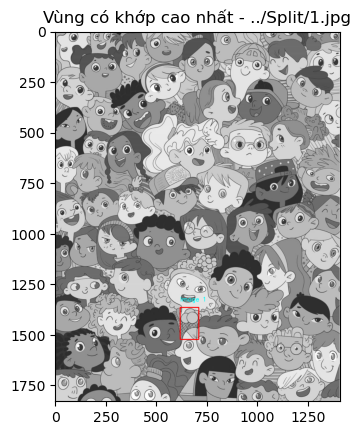

Đã lưu kết quả: result_2.jpg


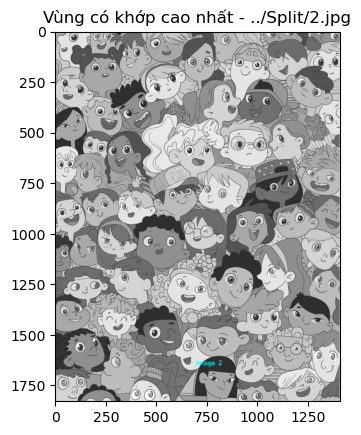

Đã lưu kết quả: result_3.jpg


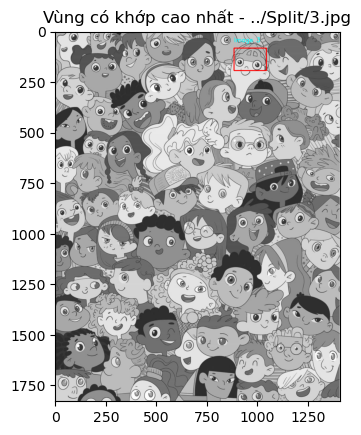

Đã lưu kết quả: result_4.jpg


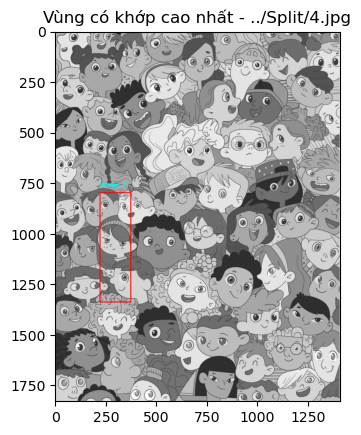

Đã lưu kết quả: result_5.jpg


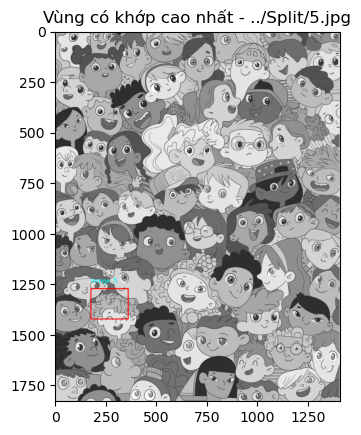

Đã lưu kết quả: result_6.jpg


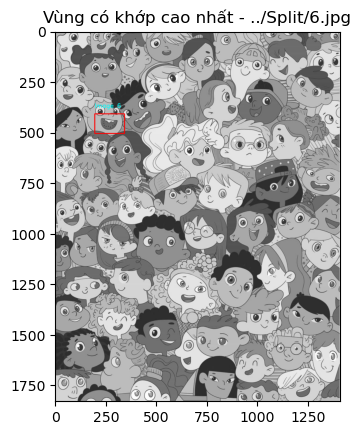

Đã lưu kết quả: result_7.jpg


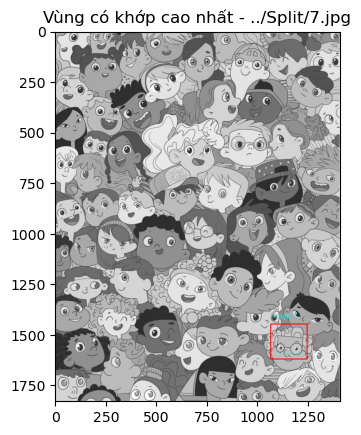

Đã lưu kết quả: result_8.jpg


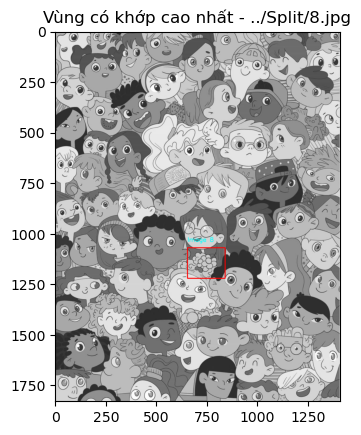

Đã lưu kết quả: result_9.jpg


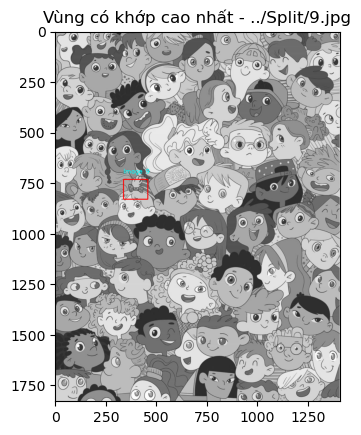

Đã lưu kết quả: result_10.jpg


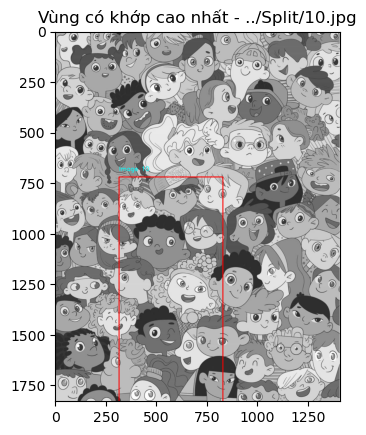

Đã lưu kết quả: result_11.jpg


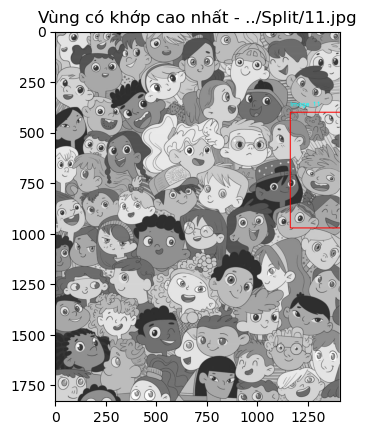

Đã lưu kết quả: result_12.jpg


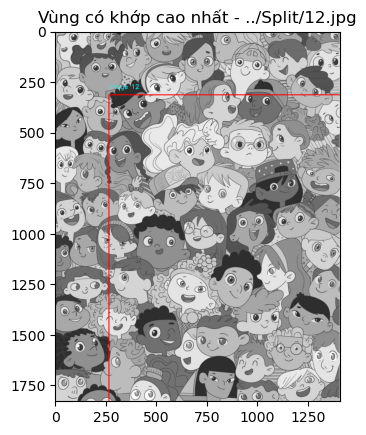

Đã lưu kết quả: result_13.jpg


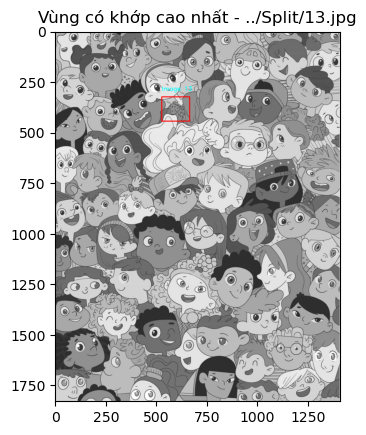

Đã lưu kết quả: result_14.jpg


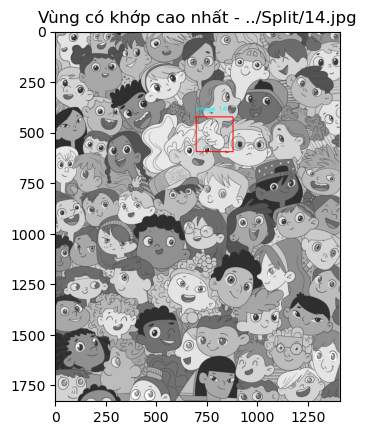

Đã lưu kết quả: result_15.jpg


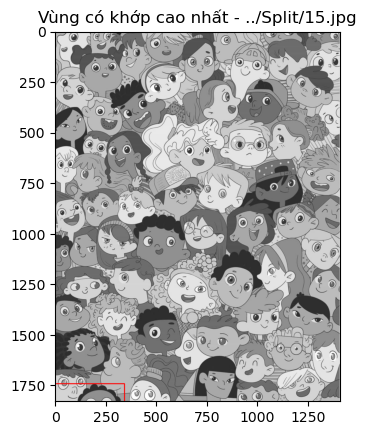

Đã lưu tọa độ vào file coordinates.csv.


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Đọc ảnh với kiểm tra lỗi
def read_image(image_path, is_gray=True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE if is_gray else cv2.IMREAD_COLOR)
    if img is None:
        print(f"Lỗi: Không thể đọc ảnh {image_path}")
    return img

# Tạo DataFrame lưu tọa độ
def create_coordinates_df():
    return pd.DataFrame(columns=['Image', 'Top_Left_X', 'Top_Left_Y', 'Bottom_Right_X', 'Bottom_Right_Y'])

# Khởi tạo SIFT và FLANN
def initialize_sift_flann():
    sift = cv2.SIFT_create()
    flann = cv2.FlannBasedMatcher(indexParams=dict(algorithm=1, trees=5), searchParams=dict(checks=100))
    return sift, flann

# Hàm khớp ảnh và tìm vùng chính xác
def find_best_match(img_large, img_template, sift, flann):
    kp1, des1 = sift.detectAndCompute(img_template, None)
    kp2, des2 = sift.detectAndCompute(img_large, None)

    matches = flann.knnMatch(np.float32(des1), np.float32(des2), k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    if len(good_matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return M, good_matches
    return None, None

# Hàm vẽ vùng và lưu kết quả
def draw_and_save_result(img_large, M, img_template, img_number):
    h, w = img_template.shape
    corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, M)
    best_corners = np.int32(transformed_corners)

    x_min, y_min = np.min(best_corners, axis=0)[0]
    x_max, y_max = np.max(best_corners, axis=0)[0]

    img_result = cv2.cvtColor(img_large, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_result, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)
    cv2.putText(img_result, f"Image {img_number}", (x_min, y_min - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    return img_result, x_min, y_min, x_max, y_max

# Hàm chính xử lý các ảnh
def process_images():
    # Đọc ảnh lớn
    img_large = read_image("../Split/left_part.jpg", is_gray=True)
    if img_large is None:
        return

    coordinates_df = create_coordinates_df()
    sift, flann = initialize_sift_flann()

    # Duyệt qua các ảnh mẫu
    for i in range(1, 16):
        img_path = f"../Split/{i}.jpg"
        img_template = read_image(img_path, is_gray=True)
        if img_template is None:
            continue

        # Khớp ảnh mẫu với ảnh lớn
        M, good_matches = find_best_match(img_large, img_template, sift, flann)
        if M is not None:
            # Vẽ vùng và lưu kết quả
            img_result, x_min, y_min, x_max, y_max = draw_and_save_result(img_large, M, img_template, i)
            
            # Lưu tọa độ vào DataFrame
            new_row = pd.DataFrame([{
                'Image': f"{img_path}",
                'Top_Left_X': x_min,
                'Top_Left_Y': y_min,
                'Bottom_Right_X': x_max,
                'Bottom_Right_Y': y_max
            }])
            coordinates_df = pd.concat([coordinates_df, new_row], ignore_index=True)

            # Lưu ảnh kết quả
            output_path = f"result_{i}.jpg"
            cv2.imwrite(output_path, img_result)
            print(f"Đã lưu kết quả: {output_path}")

            plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
            plt.title(f"Vùng có khớp cao nhất - {img_path}")
            plt.show()

    # Lưu tọa độ vào file CSV
    coordinates_df.to_csv("coordinates.csv", index=False)
    print("Đã lưu tọa độ vào file coordinates.csv.")

# Chạy hàm chính
process_images()


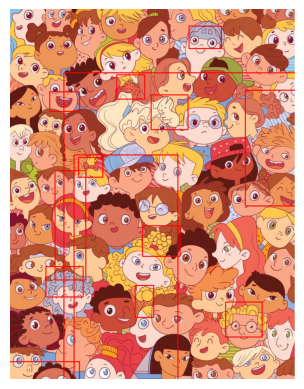

True

In [6]:
# Đọc ảnh lớn (ảnh nền màu)
img_large_color = cv2.imread("../Split/left_part.jpg")

# Đọc tọa độ từ file CSV
coordinates_df = pd.read_csv("coordinates.csv")

# Duyệt qua từng tọa độ và vẽ lên ảnh lớn
for index, row in coordinates_df.iterrows():
    # Lấy tọa độ từ CSV
    x_min = int(row['Top_Left_X'])
    y_min = int(row['Top_Left_Y'])
    x_max = int(row['Bottom_Right_X'])
    y_max = int(row['Bottom_Right_Y'])

    # Vẽ hình chữ nhật xung quanh vùng đã tìm thấy
    cv2.rectangle(img_large_color, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)  # Màu đỏ

# Hiển thị ảnh kết quả đã vẽ
plt.imshow(cv2.cvtColor(img_large_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Lưu ảnh kết quả
cv2.imwrite("SIFT_result_with_rectangles.jpg", img_large_color)